In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import dateutil
import time
from datetime import datetime
import xlrd
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# import folium
# path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# fontprop = fm.FontProperties(fname=path, size=12)
# plt.rcParams['font.sans-serif']=['NanumGothic']
# plt.rcParams['axes.unicode_minus']=False

# 코로나 데이터로 관심있는 분야 시각화
-------------

## 목표 : 코로나 시대에 도움되는 인사이트 발굴


### 1.Dacon dataset (출처 : dacon.io)
-------------
##### fpopl.csv -인구 데이터
* base_ymd : 기준년월일
* tmzon_se_code : 24시간대 구분코드
* sexdstn_se_code :  성별 구분코드 (M: 남성, F: 여성) 
* agrde_se_code : 5세단위 연령대구분코드 (단, age_00: 0세 ~ 9세, age_70: 70세 이상)
* **adstrd_code : 행정동 코드**
* popltn_cascnt : 인구수

##### adstrd_master.csv : 구로 묶을 때 사용할 것
* **adstrd_code :  행정동 코드**
* adstrd_nm : 행정동 명
* brtc_nm : 시,도 명
* **signgu_nm : 시,군,구 명**

##### card.csv : 전체 매출중 배달이 차지하는 비중?
* receipt_dttm : 카드회사가 카드사용 내역을 접수한 일자
* adstrd_code : 가맹점 위치 기준 행정동 코드
* adstrd_nm : 가맹점 위치 기준 행정동명
* mrhst_induty_cl_code : 가맹점 업종코드
* mrhst_induty_cl_nm : 가맹점 업종명
* selng_cascnt : 매출발생건수
* salamt : 매출발생금액 

##### delivery.csv : 코로나와 배달의 상관관계
* **순번**
* **처리일시 (기간별 배달 횟수 추이)**
* 배달요청업체 ID
* **배달 요청 상태값 (1:완료, 2:취소, 3:사고, 4:문의)**
* 배달접수회사 ID
* 배달상점ID
* **배달상점 업종이름(어떤 업종이 가장 인기가 많을까)**
* 배달상점 주소 법정동코드
* 배달상점 주소 법정동 시도명
* 배달상점 주소 법정동 시군구명
* 배달상점 주소 법정동 읍면동명
* 배달상점 주소 법정동 리명
* **배달상점 주소 행정동 코드(지역별 배달 데이터, 다른 데이터들과 통일할 때 사용)**
* 배달상점주소 도로명주소 코드
* 배달목적지 주소 법정동코드
* 배달목적지 주소 법정동 시도명
* 배달목적지 주소 법정동 시군구명
* 배달목적지 주소 법정동 읍면동명
* 배달목적지 주소 법정동 리명
* 배달목적지 주소 행정동 코드
* 배달목적지주소 도로명주소 코드
* **배달기사 ID ( 배달기사가 더 많아졌을까?)** 
* **배달비용 (한 업체에서 배달비를 인상한 경우가 있을까?)**
* 호출중계수수료금액
* **배달상품금액 (단체주문수가 감소했을 것. 배달 상품 가격이 낮을 수록 1인고객이 많을 것이고, 횟수가 많을 것이다.)**
* **결제종류번호 (1:카드, 2:선불, 3:현금) -결제 패턴에 변화가 있었을까?**
* **결제카드종류**
* 배달접수시간
* 배달배차시간
* 배달완료시간
* 배달취소시간

##### index.csv
* period : 기준월
* catl : 대분류
* catm : 중분류
* age
* gender
* sido
* sigungu
* **cgi : 카테고리성장지수 (2018년 월평균 대비 매출 성장 비율, 100을 기준으로 이상이면 매출 상승, 이하면 하락)**

##### COVID_19 : 서울 내 코로나 확진자수 데이터 
* case : 서울시 감염케이스 별 확진자수, 구정보. 
* patientInfo : 환자 정보
* Policy : 정책 정보. (시작,끝 날짜)
* Region : 지역별 시설 현황  
* **Time : 시간별 전체 확진자수** 
* time age : 시간별 연령대별 확진자수 



## 2. 가설 - 코로나로 인한 배달산업이 맞이한 변화
-------------

### 1. 배달 이용자 수 변화 : 
    - 코로나가 증가하면서 확진자가 증가, 자가격리자, 재택근무자가 증가하면서 배달업이 상승했을 것이다. 
### 2. 배달기사 수의 변화 : 
    - 배달업이 상승하면서 배달기사도 증가했을까? 
### 3. 결제 패턴의 변화 : 
    - 배달업을 할 때 배달기사와의 접촉을 줄이기 위해서 선불을 많이 이용했을 것이다.
### 4. 배달 품목에 따른 이용량 변화 :
    - 카페에 가지 않고 디저트나 커피를 배달을 이용해 사용했을 것이다.
    - 평소 직접 가서 먹어야만 된다고 생각했던 음식들을 배달을 이용하는 경우가 늘어날 것이다. 

## 3.Data Preprocessing & visualization
-------------

### 1. Data load

In [2]:
# #load data : 산업 데이터
df_card = pd.read_csv("../data/card_20200717.csv", encoding='utf-8') 
df_del = pd.read_csv("../data/delivery.csv", encoding='utf-8') 
# df_fpop = pd.read_csv("data/fpopl.csv",encoding="utf-8" ) 
# df_adstrd = pd.read_csv("data/adstrd_master.csv")
# df_index = pd.read_csv("data/index.csv")
# df_EK = pd.read_excel("data/COVID_eng_kor_table.xlsx")

In [3]:
#load data : 코로나 확진자 관련 데이터 
df_case = pd.read_csv("../data/COVID_19/Case.csv", encoding='utf-8')
# df_policy =  pd.read_csv("data/COVID_19/Policy.csv", encoding='utf-8')
df_TimePatient =  pd.read_csv("../data/COVID_19/Time.csv", encoding='utf-8')

In [4]:
df_case.head()

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,서울,용산구,True,Itaewon Clubs,139,37.538621,126.992652
1,1000002,서울,관악구,True,Richway,119,37.48208,126.901384
2,1000003,서울,구로구,True,Guro-gu Call Center,95,37.508163,126.884387
3,1000004,서울,양천구,True,Yangcheon Table Tennis Club,43,37.546061,126.874209
4,1000005,서울,도봉구,True,Day Care Center,43,37.679422,127.044374


### 2. preprocessing
-------------


#### 0. 카드 매출 데이터 

In [5]:
df_card.head()

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
0,20200104,1174066000,성내3동,7041,약국,463,5843230
1,20200104,1174066000,성내3동,7022,치과의원,33,7835550
2,20200104,1174066000,성내3동,7021,한의원,53,4589800
3,20200104,1174066000,성내3동,7020,의원,339,9267240
4,20200104,1174066000,성내3동,6110,자동차정비,19,4441000


In [6]:
#date컬럼 타입 변경
df_card['receipt_dttm'] = df_card["receipt_dttm"].apply(str)
df_card["receipt_dttm"] = pd.to_datetime(df_card["receipt_dttm"])

In [7]:
df_card.head()

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
0,2020-01-04,1174066000,성내3동,7041,약국,463,5843230
1,2020-01-04,1174066000,성내3동,7022,치과의원,33,7835550
2,2020-01-04,1174066000,성내3동,7021,한의원,53,4589800
3,2020-01-04,1174066000,성내3동,7020,의원,339,9267240
4,2020-01-04,1174066000,성내3동,6110,자동차정비,19,4441000


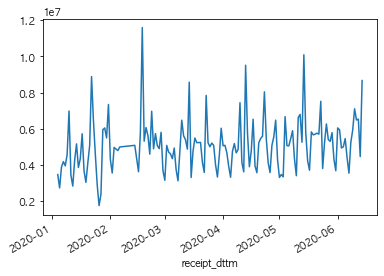

In [8]:
df_card.groupby('receipt_dttm')['selng_cascnt'].sum().plot()

Text(0.5, 1.0, '전체 소비량 이동평균')

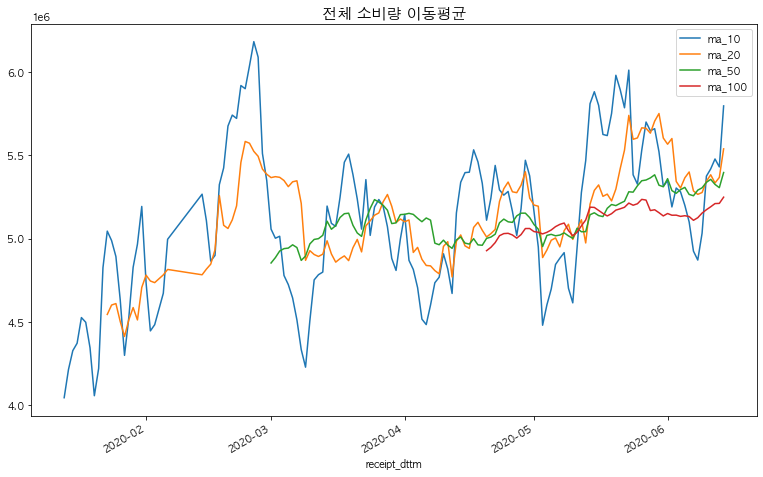

In [9]:
plt.figure(figsize=(13,8))
df_card.groupby('receipt_dttm')['selng_cascnt'].sum().rolling(10).mean().plot()
df_card.groupby('receipt_dttm')['selng_cascnt'].sum().rolling(20).mean().plot()
df_card.groupby('receipt_dttm')['selng_cascnt'].sum().rolling(50).mean().plot()
df_card.groupby('receipt_dttm')['selng_cascnt'].sum().rolling(100).mean().plot()
plt.legend(['ma_10','ma_20','ma_50','ma_100'])
plt.title("전체 소비량 이동평균", fontsize=15)

In [10]:
df_cardsum =pd.DataFrame(df_card.groupby('receipt_dttm')['selng_cascnt'].sum()).reset_index()

In [11]:
df_cardsum.head()

,receipt_dttm,selng_cascnt
0,2020-01-04,3485355
1,2020-01-05,2748290
2,2020-01-06,3911133
3,2020-01-07,4196355
4,2020-01-08,3966219


In [12]:
df_card.groupby('receipt_dttm')['selng_cascnt'].sum()

receipt_dttm
2020-01-04    3485355
2020-01-05    2748290
2020-01-06    3911133
2020-01-07    4196355
2020-01-08    3966219
               ...   
2020-06-10    7114065
2020-06-11    6495485
2020-06-12    6544058
2020-06-13    4477241
2020-06-14    8670915
Name: selng_cascnt, Length: 155, dtype: int64

#### 카드 소비량이 3월부터 낮아짐

#### 1. 코로나 지역별 확진자수 데이터 - df_case

In [13]:
#전국 지역별 자가격리,확진자 수
pd.DataFrame(df_case.groupby('province')['confirmed'].sum().sort_values(ascending = False)).head() 

,confirmed
province,
대구,6680
경상북도,1324
서울,1280
경기도,1000
인천,202


In [14]:
#지역별 자가격리자(접촉자,해외귀국자)
pd.DataFrame(df_case[df_case['group']==False].groupby('province')['confirmed'].sum().sort_values(ascending = False)).head()

,confirmed
province,
대구,1705
서울,560
경기도,452
경상북도,345
부산,85


In [15]:
#지역별 확진자수 
df_coronaK = pd.DataFrame(df_case[df_case['group']==True].groupby('province')['confirmed'].sum().sort_values(ascending = False)).head()
df_coronaK

,confirmed
province,
대구,4975
경상북도,979
서울,720
경기도,548
충청남도,128


In [16]:
df_seoulcorona = pd.DataFrame(df_case[df_case['province'] == "서울"].groupby('city')['confirmed'].sum().sort_values(ascending = False)).head(10)
df_seoulcorona.head()

,confirmed
city,
-,561
관악구,149
용산구,139
구로구,139
타도시,82


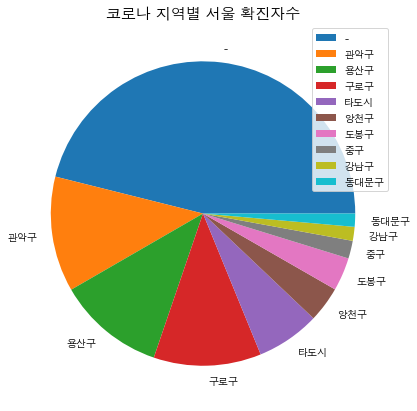

In [17]:
plt.figure(figsize=(10,7))
plt.pie(df_seoulcorona["confirmed"], labels = df_seoulcorona.index)
plt.title("코로나 지역별 서울 확진자수", fontsize=15)
plt.legend()
plt.show()

#### 2. 코로나 일별 확진자수 추이 - df_timepatient
* 날짜에 따른 검사횟수, 양성 및 음성, 확진자수, 완치, 사망 데이터

In [18]:
#시간별 주적확진자수 - 격리해제 수 ,2020-01-20~2020-06-30
df_TimePatient.tail()

,date,time,test,negative,confirmed,released,deceased
158,2020-06-26,0,1232315,1200885,12602,11172,282
159,2020-06-27,0,1243780,1211261,12653,11317,282
160,2020-06-28,0,1251695,1219975,12715,11364,282
161,2020-06-29,0,1259954,1228698,12757,11429,282
162,2020-06-30,0,1273766,1240157,12800,11537,282


In [19]:
#date컬럼 타입 변경
df_TimePatient.date = pd.to_datetime(df_TimePatient.date)

In [20]:
#시간별 누적확진자수 - 격리해제 수
df_TimePatient["new_confirmed"] = pd.DataFrame(df_TimePatient['confirmed']-df_TimePatient['released'])

#### 2-1. 일별 코로나 확진자 수 

Text(0.5, 1.0, '코로나 확진자 추이')

<Figure size 720x504 with 0 Axes>

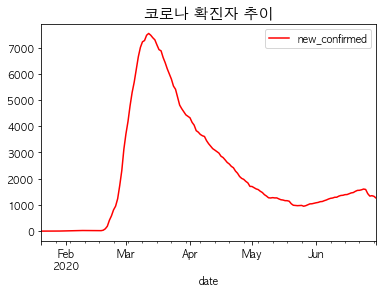

In [21]:
#날짜별 확진자수 추이
plt.figure(figsize=(10,7))
df_TimePatient[["date","new_confirmed"]].plot('date','new_confirmed',c='r')
plt.title("코로나 확진자 추이", fontsize=15)

In [22]:
#월별 확진자수 
df_TimePatient['Date1'] = df_TimePatient['date'].dt.month
df_TP_m = df_TimePatient[df_TimePatient['Date1'] > 1]


In [23]:
df_TP = df_TP_m[['date','new_confirmed']]
df_TP.index = df_TP['date']
df_TP.head()
del df_TP["date"]

In [24]:
df_TP.head()

,new_confirmed
date,
2020-02-01,12
2020-02-02,15
2020-02-03,15
2020-02-04,16
2020-02-05,17


#### 2-2. 월별 코로나 확진자 수
 - 3~4월에 가장 많고 점차 확진자들이 줄어드는 추세이다. 

Text(0.5, 1.0, '코로나 월별 확진자')

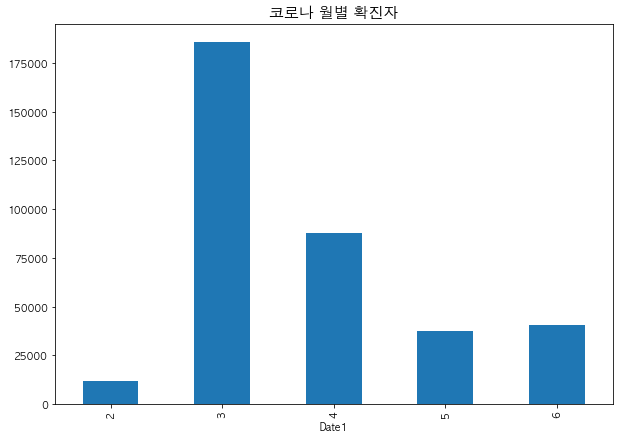

In [25]:
plt.figure(figsize=(10,7))
df_TP_m.groupby('Date1')['new_confirmed'].sum().plot.bar()
plt.title("코로나 월별 확진자", fontsize=15)

#### 3. 배달데이터 전처리 및 시각화 - df_del

In [26]:
df_del.head()

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,...,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME
0,4577985,2020-01-01,C000035,1,C000035,S0032342,치킨,4812710600,경상남도,창원시 마산회원구,...,D0005271,4290,300,25000,1,승인:비씨카드사,2020-01-01 00:15:49,2020-01-01 00:21:38,2020-01-01 00:41:37,NaN
1,4577986,2020-01-01,C000237,1,C000237,S0021847,찜탕,4121010200,경기도,광명시,...,D0003269,4800,200,49000,2,NaN,2020-01-01 01:12:14,2020-01-01 01:21:41,2020-01-01 01:31:44,NaN
2,4577988,2020-01-01,C000129,1,C000129,S0025740,치킨,1138010400,서울특별시,은평구,...,D0001536,3300,300,23000,3,승인:,2020-01-01 00:01:14,2020-01-01 00:01:47,2020-01-01 00:18:47,NaN
3,4577989,2020-01-01,C000029,1,C000043,S0039634,한식,4115010100,경기도,의정부시,...,D0005061,4500,300,20000,2,NaN,2020-01-01 01:01:34,2020-01-01 01:28:06,2020-01-01 01:36:48,NaN
4,4577991,2020-01-01,C000130,1,C000130,S0002237,한식,4128112800,경기도,고양시 덕양구,...,D0005215,6500,300,32000,2,NaN,2020-01-01 01:05:06,2020-01-01 01:08:01,2020-01-01 01:29:00,NaN


In [27]:
#날짜 데이터 date type 변형
df_del['PROCESS_DT'] = pd.to_datetime(df_del['PROCESS_DT'])

In [28]:
df_del_seoul = df_del[df_del['DLVR_STORE_SIDO']=='서울특별시']
df_del_seoul.head()

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,...,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME
2,4577988,2020-01-01,C000129,1,C000129,S0025740,치킨,1138010400,서울특별시,은평구,...,D0001536,3300,300,23000,3,승인:,2020-01-01 00:01:14,2020-01-01 00:01:47,2020-01-01 00:18:47,NaN
6,4577994,2020-01-01,C000049,1,C000049,S0022461,분식,1153010800,서울특별시,구로구,...,D0004461,3800,300,28000,2,NaN,2020-01-01 01:27:00,2020-01-01 01:27:47,2020-01-01 01:41:45,NaN
8,4577996,2020-01-01,C000104,1,C000101,S0021988,치킨,1156013300,서울특별시,영등포구,...,D0006259,4800,200,17000,1,승인:KB국민카드,2020-01-01 00:51:49,2020-01-01 00:52:12,2020-01-01 01:23:41,NaN
24,4578014,2020-01-01,C000101,1,C000104,S0021942,치킨,1156013200,서울특별시,영등포구,...,D0006407,3900,300,19000,2,NaN,2020-01-01 00:02:53,2020-01-01 00:16:01,2020-01-01 00:42:53,NaN
29,4578020,2020-01-01,C000209,1,C000209,S0022364,치킨,1154510200,서울특별시,금천구,...,D0003816,4300,300,21000,1,승인:하나카드,2020-01-01 01:27:08,2020-01-01 01:27:25,2020-01-01 01:37:01,NaN


#### 3-1. 전국 총 배달량 추이

Text(0.5, 1.0, '전국 일 별 총 배달량 추이')

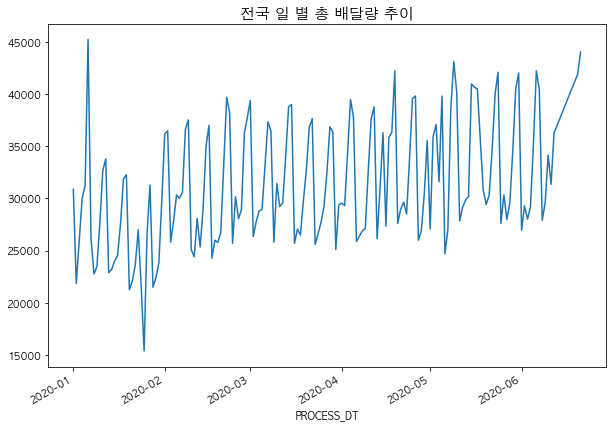

In [121]:
plt.figure(figsize=(10,7))
df_del.groupby('PROCESS_DT')['SERIAL_NUMBER'].count().plot()
plt.title("전국 일 별 총 배달량 추이", fontsize=15)

In [30]:
cnt_del = pd.DataFrame(df_del.groupby('PROCESS_DT')['SERIAL_NUMBER'].count())

#### 이동평균을 통한 배달량 추이 파악

In [31]:
def rolling_mean(df) :
    df.rolling(10).mean().plot()
    df.rolling(20).mean().plot()
    df.rolling(50).mean().plot()
    df.rolling(100).mean().plot()
    plt.legend(['ma_10','ma_20','ma_50','ma_100'])
    

Text(0.5, 1.0, '전국 배달량 이동평균')

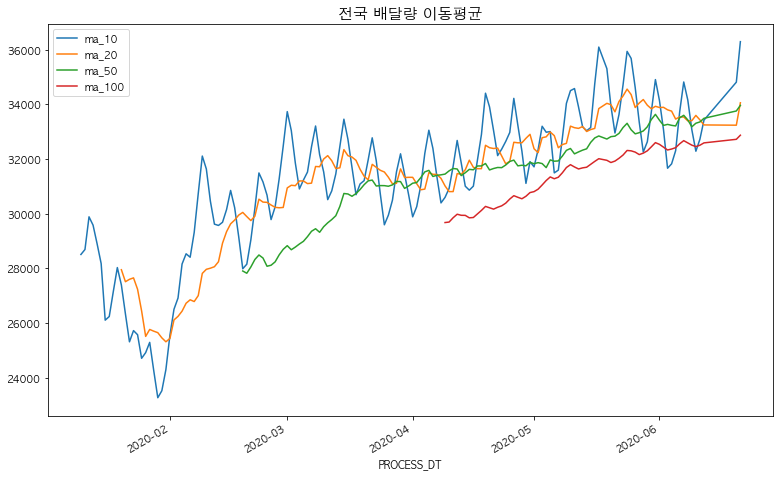

In [32]:
plt.figure(figsize=(13,8))
cnt_del['SERIAL_NUMBER'].rolling(10).mean().plot()
cnt_del['SERIAL_NUMBER'].rolling(20).mean().plot()
cnt_del['SERIAL_NUMBER'].rolling(50).mean().plot()
cnt_del['SERIAL_NUMBER'].rolling(100).mean().plot()
plt.legend(['ma_10','ma_20','ma_50','ma_100'])
plt.title("전국 배달량 이동평균", fontsize=15)

Text(0.5, 1.0, '코로나 확진자수')

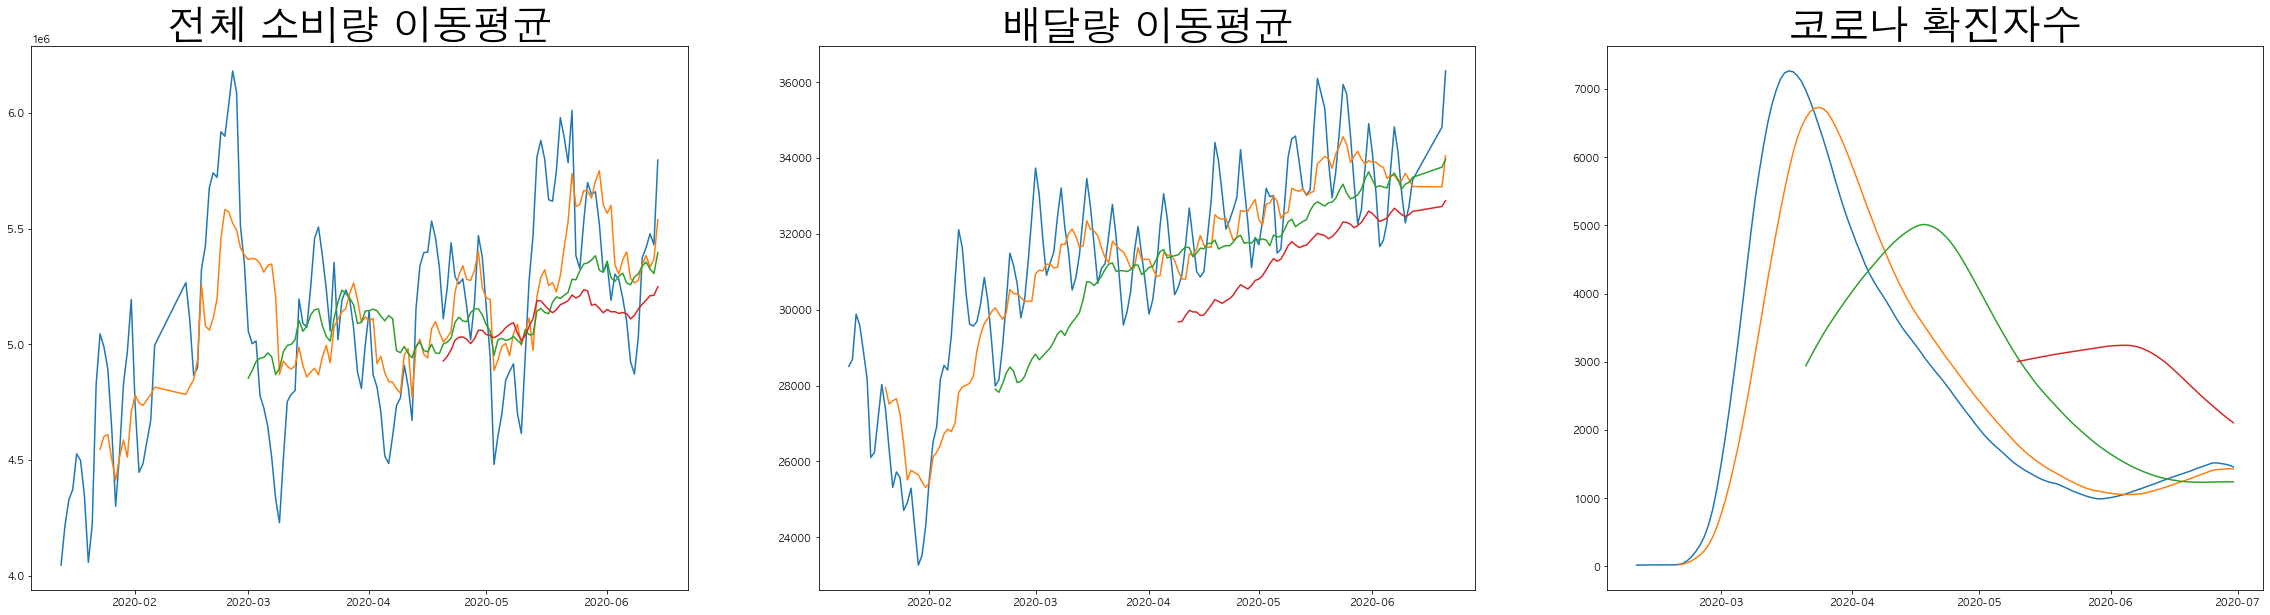

In [33]:
fig, ax = plt.subplots(1, 3,figsize=(40,10)) # 각 액자들에 그래프를 그린다. 
ax[0].plot(df_card.groupby('receipt_dttm')['selng_cascnt'].sum().rolling(10).mean()) 
ax[0].plot(df_card.groupby('receipt_dttm')['selng_cascnt'].sum().rolling(20).mean()) 
ax[0].plot(df_card.groupby('receipt_dttm')['selng_cascnt'].sum().rolling(50).mean()) 
ax[0].plot(df_card.groupby('receipt_dttm')['selng_cascnt'].sum().rolling(100).mean()) 
ax[0].set_title("전체 소비량 이동평균",fontsize =40)


ax[1].plot(cnt_del['SERIAL_NUMBER'].rolling(10).mean()) 
ax[1].plot(cnt_del['SERIAL_NUMBER'].rolling(20).mean()) 
ax[1].plot(cnt_del['SERIAL_NUMBER'].rolling(50).mean()) 
ax[1].plot(cnt_del['SERIAL_NUMBER'].rolling(100).mean()) 
ax[1].set_title("배달량 이동평균",fontsize =40)

ax[2].plot(df_TP.rolling(10).mean())
ax[2].plot(df_TP.rolling(20).mean())
ax[2].plot(df_TP.rolling(50).mean())
ax[2].plot(df_TP.rolling(100).mean())
ax[2].set_title("코로나 확진자수",fontsize =40)

In [34]:
df_del_seoul.groupby('DLVR_STORE_SIGUNGU')['SERIAL_NUMBER'].count().sort_values(ascending=False)

DLVR_STORE_SIGUNGU
구로구     290123
금천구     139438
영등포구    124333
도봉구      76891
은평구      55212
동작구      42217
관악구      25763
노원구      16327
양천구      15279
서초구       2766
서대문구      2692
Name: SERIAL_NUMBER, dtype: int64

#### 3-2. 지역별 배달량

In [35]:
df_local = df_del_seoul.groupby('DLVR_STORE_SIGUNGU')['SERIAL_NUMBER'].count().sort_values(ascending=False)

In [36]:
df_local.index

Index(['구로구', '금천구', '영등포구', '도봉구', '은평구', '동작구', '관악구', '노원구', '양천구', '서초구',
       '서대문구'],
      dtype='object', name='DLVR_STORE_SIGUNGU')

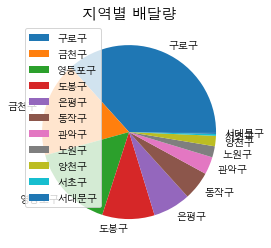

In [37]:
plt.pie(df_local, labels = df_local.index)
plt.title("지역별 배달량", fontsize=15)
plt.legend()
plt.show()

#### 배달량이 많고, 코로나 확진자도 많이 나온 지역 5개만 뽑아서 분석

In [38]:
top5 = ['관악구','구로구','양천구','도봉구','은평구']

In [39]:
df_del_gw = df_del_seoul[df_del_seoul['DLVR_STORE_SIGUNGU'] == top5[0]]
df_del_gr = df_del_seoul[df_del_seoul['DLVR_STORE_SIGUNGU'] == top5[1]]
df_del_yc = df_del_seoul[df_del_seoul['DLVR_STORE_SIGUNGU'] == top5[2]]
df_del_db = df_del_seoul[df_del_seoul['DLVR_STORE_SIGUNGU'] == top5[3]]
df_del_up = df_del_seoul[df_del_seoul['DLVR_STORE_SIGUNGU'] == top5[4]]

In [40]:
top5_list = [df_del_gw,df_del_gr,df_del_yc,df_del_db,df_del_up]

In [41]:
def groupmat(list) :
    for i in list :
        i.groupby('PROCESS_DT')['SERIAL_NUMBER'].count().plot()

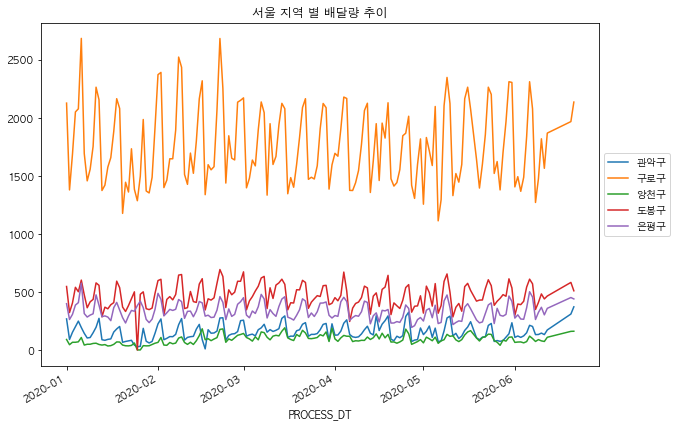

In [42]:
plt.figure(figsize=(10,7))
plt.title("서울 지역 별 배달량 추이")
groupmat(top5_list)
plt.legend(['관악구','구로구','양천구','도봉구','은평구'],loc='center left', bbox_to_anchor=(1, 0.5))

In [43]:
df_del_seoul['Date1'] = df_del_seoul['PROCESS_DT'].dt.month

<ipython-input-43-c3df43af6f81>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_del_seoul['Date1'] = df_del_seoul['PROCESS_DT'].dt.month


In [44]:
# 2020-06-21 까지의 데이터
df_del_seoul.tail()

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,...,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME,Date1
5158277,10672639,2020-06-21,C000129,1,C000129,S0035127,회,1138010400,서울특별시,은평구,...,3500,400,28000,2,NaN,2020-06-21 23:37:12,2020-06-21 23:37:22,2020-06-21 23:46:17,NaN,6
5158279,10672642,2020-06-21,C000049,1,C000237,S0022444,한식,1153010600,서울특별시,구로구,...,3300,300,18900,2,NaN,2020-06-21 23:04:02,2020-06-21 23:08:38,2020-06-21 23:18:13,NaN,6
5158298,10672664,2020-06-21,C000209,1,C000210,S0019627,배달전문업체,1154510200,서울특별시,금천구,...,3300,200,21900,2,NaN,2020-06-21 23:37:27,2020-06-21 23:38:01,2020-06-21 23:48:26,NaN,6
5158320,10672689,2020-06-21,C000026,1,C000026,S0026242,야식,1132010800,서울특별시,도봉구,...,3600,55,22000,2,NaN,2020-06-21 22:57:15,2020-06-21 22:58:00,2020-06-21 23:18:20,NaN,6
5158323,10672692,2020-06-21,C000209,1,C000209,S0022227,야식,1154510300,서울특별시,금천구,...,4730,300,46000,2,NaN,2020-06-21 23:04:50,2020-06-21 23:14:35,2020-06-21 23:28:22,NaN,6


In [45]:
month_del = pd.DataFrame(df_del_seoul.groupby('Date1')['SERIAL_NUMBER'].count())

In [46]:
month_del['SERIAL_NUMBER'][6] = 66328*3/2

In [47]:
month_del

,SERIAL_NUMBER
Date1,
1,136943
2,145942
3,154268
4,142626
5,144934
6,99492


#### 3-3. 월별 배달량

Text(0.5, 1.0, '서울 월별 배달량')

<Figure size 720x720 with 0 Axes>

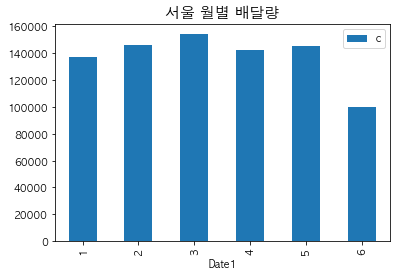

In [48]:
plt.figure(figsize=(10,10))
month_del.plot.bar()
plt.legend("cnt")
plt.title("서울 월별 배달량", fontsize=15)

* 확진자,격리자가 가장 많은 3월에 배달량도 가장 많다

#### 요일별 주기 확인 

In [49]:
df_del_seoul['Date2'] = df_del_seoul['PROCESS_DT'].dt.dayofweek

<ipython-input-49-0c582efcb479>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_del_seoul['Date2'] = df_del_seoul['PROCESS_DT'].dt.dayofweek


In [50]:
weeklist= ['월','화','수','목','금','토','일']
df_del_seoul['Date3'] = '월'

<ipython-input-50-48f3b9632fc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_del_seoul['Date3'] = '월'


In [51]:
df_del_seoul['Date3'][df_del_seoul['Date2'] == 1] = '화'
df_del_seoul['Date3'][df_del_seoul['Date2'] == 2] = '수'
df_del_seoul['Date3'][df_del_seoul['Date2'] == 3] = '목'
df_del_seoul['Date3'][df_del_seoul['Date2'] == 4] = '금'
df_del_seoul['Date3'][df_del_seoul['Date2'] == 5] = '토'
df_del_seoul['Date3'][df_del_seoul['Date2'] == 6] = '일'


<ipython-input-51-cc19ee2a6299>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_del_seoul['Date3'][df_del_seoul['Date2'] == 1] = '화'
/Users/kkyuhun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-51-cc19ee2a6299>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_del_seoul['Date3'][df_del_seoul['Date2'] == 2] = '수'
<i

In [52]:
df_del_seoul.head()

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,...,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME,Date1,Date2,Date3
2,4577988,2020-01-01,C000129,1,C000129,S0025740,치킨,1138010400,서울특별시,은평구,...,23000,3,승인:,2020-01-01 00:01:14,2020-01-01 00:01:47,2020-01-01 00:18:47,NaN,1,2,수
6,4577994,2020-01-01,C000049,1,C000049,S0022461,분식,1153010800,서울특별시,구로구,...,28000,2,NaN,2020-01-01 01:27:00,2020-01-01 01:27:47,2020-01-01 01:41:45,NaN,1,2,수
8,4577996,2020-01-01,C000104,1,C000101,S0021988,치킨,1156013300,서울특별시,영등포구,...,17000,1,승인:KB국민카드,2020-01-01 00:51:49,2020-01-01 00:52:12,2020-01-01 01:23:41,NaN,1,2,수
24,4578014,2020-01-01,C000101,1,C000104,S0021942,치킨,1156013200,서울특별시,영등포구,...,19000,2,NaN,2020-01-01 00:02:53,2020-01-01 00:16:01,2020-01-01 00:42:53,NaN,1,2,수
29,4578020,2020-01-01,C000209,1,C000209,S0022364,치킨,1154510200,서울특별시,금천구,...,21000,1,승인:하나카드,2020-01-01 01:27:08,2020-01-01 01:27:25,2020-01-01 01:37:01,NaN,1,2,수


#### 3-4. 요일별 배달량
- 평일에 비해 상대적으로 금,토,일 요일에 배달량이 많은 것을 확인할 수 있다.
- 월별 배달량보다 요일에 따른 배달량 차이가 큼

Text(0.5, 1.0, '서울 요일별 배달량')

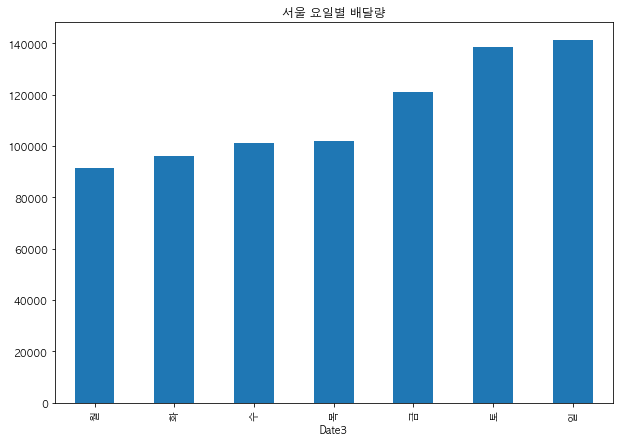

In [53]:
plt.figure(figsize=(10,7))
df_del_seoul.groupby('Date3')['Date2'].count().sort_values().plot.bar()
plt.title("서울 요일별 배달량")
#라벨

In [54]:
# 서울 내 일일 배달수 
del_cnt = pd.DataFrame(df_del_seoul.groupby('PROCESS_DT')['SERIAL_NUMBER'].count())

In [55]:
del_cnt = del_cnt.reset_index()
del_cnt.head()

,PROCESS_DT,SERIAL_NUMBER
0,2020-01-01,5455
1,2020-01-02,3491
2,2020-01-03,4341
3,2020-01-04,5270
4,2020-01-05,5374


In [56]:
del_cnt['month'] = del_cnt['PROCESS_DT'].dt.month

In [57]:
del_cnt['weekday'] = del_cnt['PROCESS_DT'].dt.dayofweek

In [58]:
del_cnt.head()

,PROCESS_DT,SERIAL_NUMBER,month,weekday
0,2020-01-01,5455,1,2
1,2020-01-02,3491,1,3
2,2020-01-03,4341,1,4
3,2020-01-04,5270,1,5
4,2020-01-05,5374,1,6


In [59]:
del_cnt.corr()

,SERIAL_NUMBER,month,weekday
SERIAL_NUMBER,1.000000,0.062563,0.715562
month,0.062563,1.000000,0.024947
weekday,0.715562,0.024947,1.000000


In [60]:
del_cnt = del_cnt.rename({'PROCESS_DT' : 'date'},axis ='columns')
del_cnt.head()

,date,SERIAL_NUMBER,month,weekday
0,2020-01-01,5455,1,2
1,2020-01-02,3491,1,3
2,2020-01-03,4341,1,4
3,2020-01-04,5270,1,5
4,2020-01-05,5374,1,6


In [61]:
df_con = df_TimePatient[["date","new_confirmed"]]
df_con.head()

,date,new_confirmed
0,2020-01-20,1
1,2020-01-21,1
2,2020-01-22,1
3,2020-01-23,1
4,2020-01-24,2


#### 상관관계 (월, 주 , 코로나 확진자, 배달건수)

In [62]:
df_cor_del = pd.merge(df_con,del_cnt, on="date")
df_cor_del.head()

,date,new_confirmed,SERIAL_NUMBER,month,weekday
0,2020-01-20,1,3396,1,0
1,2020-01-21,1,3511,1,1
2,2020-01-22,1,3641,1,2
3,2020-01-23,1,4318,1,3
4,2020-01-24,2,3773,1,4


In [63]:
df_cor_del.describe()

,new_confirmed,SERIAL_NUMBER,month,weekday
count,146.000000,146.000000,146.000000,146.000000
mean,2325.472603,4802.136986,3.541096,3.020548
std,2240.911373,914.193820,1.462764,1.998169
min,1.000000,2885.000000,1.000000,0.000000
25%,950.750000,4023.000000,2.000000,1.000000
50%,1364.500000,4586.500000,4.000000,3.000000
75%,3673.750000,5716.750000,5.000000,5.000000
max,7536.000000,6947.000000,6.000000,6.000000


In [64]:
df_cor_del.corr()

,new_confirmed,SERIAL_NUMBER,month,weekday
new_confirmed,1.000000,0.131803,0.037315,0.003776
SERIAL_NUMBER,0.131803,1.000000,0.062605,0.770831
month,0.037315,0.062605,1.000000,0.055158
weekday,0.003776,0.770831,0.055158,1.000000


#### 3.5 배달수와 요일,월,코로나 확진자 수의 상관관계
- 요일 = 0.77
- 확진자수 =0.13
- 월 = 0.04

Text(0.5, 1.0, '배달수-코로나-날짜 상관관계')

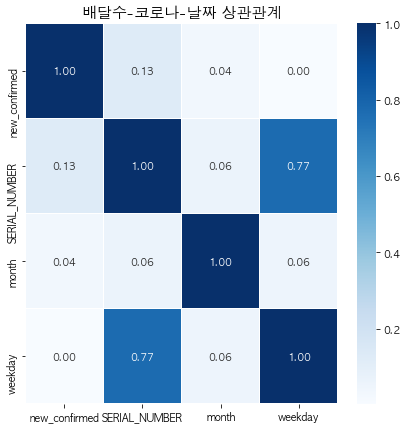

In [65]:
plt.figure(figsize=(7,7))
sns.heatmap(data = df_cor_del.corr(), annot =True, fmt='.2f', linewidths=.5,cmap='Blues')
plt.title("배달수-코로나-날짜 상관관계", fontsize=15)

#### 배달기사 수 의 변화?

In [66]:
df_del['DLVR_MAN_ID'].count()

5158324

In [67]:
df_del.head()

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,...,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME
0,4577985,2020-01-01,C000035,1,C000035,S0032342,치킨,4812710600,경상남도,창원시 마산회원구,...,D0005271,4290,300,25000,1,승인:비씨카드사,2020-01-01 00:15:49,2020-01-01 00:21:38,2020-01-01 00:41:37,NaN
1,4577986,2020-01-01,C000237,1,C000237,S0021847,찜탕,4121010200,경기도,광명시,...,D0003269,4800,200,49000,2,NaN,2020-01-01 01:12:14,2020-01-01 01:21:41,2020-01-01 01:31:44,NaN
2,4577988,2020-01-01,C000129,1,C000129,S0025740,치킨,1138010400,서울특별시,은평구,...,D0001536,3300,300,23000,3,승인:,2020-01-01 00:01:14,2020-01-01 00:01:47,2020-01-01 00:18:47,NaN
3,4577989,2020-01-01,C000029,1,C000043,S0039634,한식,4115010100,경기도,의정부시,...,D0005061,4500,300,20000,2,NaN,2020-01-01 01:01:34,2020-01-01 01:28:06,2020-01-01 01:36:48,NaN
4,4577991,2020-01-01,C000130,1,C000130,S0002237,한식,4128112800,경기도,고양시 덕양구,...,D0005215,6500,300,32000,2,NaN,2020-01-01 01:05:06,2020-01-01 01:08:01,2020-01-01 01:29:00,NaN


In [68]:
df_del['DLVR_MAN_ID'].unique()

array(['D0005271', 'D0003269', 'D0001536', ..., 'D0013382', 'D0013684',
       'D0012984'], dtype=object)

In [69]:
df_del_man = pd.DataFrame(df_del.groupby('PROCESS_DT')['DLVR_MAN_ID'].unique())
df_del_man

,DLVR_MAN_ID
PROCESS_DT,
2020-01-01,"[D0005271, D0003269, D0001536, D0005061, D0005..."
2020-01-02,"[D0006234, D0007359, D0006162, D0002092, D0005..."
2020-01-03,"[D0005271, D0004983, D0006138, D0006619, D0000..."
2020-01-04,"[D0006227, D0006428, D0003399, D0001024, D0000..."
2020-01-05,"[D0005982, D0006222, D0004486, D0001971, D0000..."
...,...
2020-06-10,"[D0013149, D0005787, D0013029, D0010347, D0010..."
2020-06-11,"[D0005903, D0013718, D0010287, D0003249, D0013..."
2020-06-12,"[D0012903, D0008242, D0012374, D0001628, D0011..."


In [70]:
df_del_man = df_del_man['DLVR_MAN_ID'].reset_index()
df_del_man.head()

,PROCESS_DT,DLVR_MAN_ID
0,2020-01-01,"[D0005271, D0003269, D0001536, D0005061, D0005..."
1,2020-01-02,"[D0006234, D0007359, D0006162, D0002092, D0005..."
2,2020-01-03,"[D0005271, D0004983, D0006138, D0006619, D0000..."
3,2020-01-04,"[D0006227, D0006428, D0003399, D0001024, D0000..."
4,2020-01-05,"[D0005982, D0006222, D0004486, D0001971, D0000..."


In [71]:
len(df_del_man)

165

In [72]:
df_del_man['cnt'] = 0

In [73]:
for i in range(165) : 
    df_del_man['cnt'][i] = len(df_del_man['DLVR_MAN_ID'][i])

<ipython-input-73-054bb8cba45b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_del_man['cnt'][i] = len(df_del_man['DLVR_MAN_ID'][i])


In [74]:
df_del_man['PROCESS_DT'] = pd.to_datetime(df_del_man['PROCESS_DT'])

In [75]:
df_del_man.head()

,PROCESS_DT,DLVR_MAN_ID,cnt
0,2020-01-01,"[D0005271, D0003269, D0001536, D0005061, D0005...",1279
1,2020-01-02,"[D0006234, D0007359, D0006162, D0002092, D0005...",1243
2,2020-01-03,"[D0005271, D0004983, D0006138, D0006619, D0000...",1315
3,2020-01-04,"[D0006227, D0006428, D0003399, D0001024, D0000...",1381
4,2020-01-05,"[D0005982, D0006222, D0004486, D0001971, D0000...",1349


### 3.6 배달기사 수의 변화
#### 가설 : 배달의 이용이 증가하는 만큼 배달기사의 수도 증가할 것이다. 
- 배달기사수가 꾸준히 증가하는 추세이다
- 배달 기사의 수도 주기성을 띄고있는데 이는 주말에만 배달을 하는 기사들이 존재해서 그런 것으로 보인다.
- 2020-01-24~2020-01-27. 설날에는 배달을 거의 이용하지 않고 배달기사들이 일을 하지 않았다.

<Figure size 720x504 with 0 Axes>

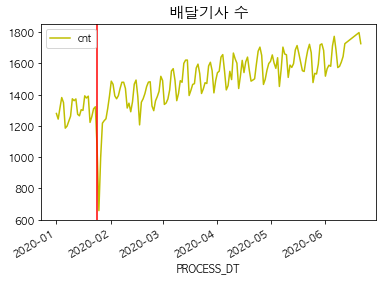

In [76]:
plt.figure(figsize=(10,7))
df_del_man[['PROCESS_DT','cnt']].plot('PROCESS_DT','cnt',c='y')
plt.title("배달기사 수", fontsize=15)
plt.axvline('2020-01-24', color='r')

In [77]:
df_dm = df_del_man.set_index('PROCESS_DT')

In [78]:
del df_dm['DLVR_MAN_ID']

In [79]:
df_dm.head()

,cnt
PROCESS_DT,
2020-01-01,1279
2020-01-02,1243
2020-01-03,1315
2020-01-04,1381
2020-01-05,1349


In [80]:
# 요일데이터
df_dm_w = df_dm.reset_index()
df_dm_w.head()

,PROCESS_DT,cnt
0,2020-01-01,1279
1,2020-01-02,1243
2,2020-01-03,1315
3,2020-01-04,1381
4,2020-01-05,1349


In [81]:
df_dm_w['week'] = df_dm_w['PROCESS_DT'].dt.dayofweek
df_dm_w.head()

,PROCESS_DT,cnt,week
0,2020-01-01,1279,2
1,2020-01-02,1243,3
2,2020-01-03,1315,4
3,2020-01-04,1381,5
4,2020-01-05,1349,6


In [82]:
df_dm_w['weekday'] = '월'
df_dm_w['weekday'][df_dm_w['week'] == 1] = '화'
df_dm_w['weekday'][df_dm_w['week'] == 2] = '수'
df_dm_w['weekday'][df_dm_w['week'] == 3] = '목'
df_dm_w['weekday'][df_dm_w['week'] == 4] = '금'
df_dm_w['weekday'][df_dm_w['week'] == 5] = '토'
df_dm_w['weekday'][df_dm_w['week'] == 6] = '일'
df_dm_w.head(10)

<ipython-input-82-a9a2cdaec685>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dm_w['weekday'][df_dm_w['week'] == 1] = '화'
<ipython-input-82-a9a2cdaec685>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dm_w['weekday'][df_dm_w['week'] == 2] = '수'
<ipython-input-82-a9a2cdaec685>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dm_w['weekday'][df_dm_w['week'] == 3] = '목'
<ipython-input-82-a9a2cdaec685>:5: SettingWithCopyWarni

,PROCESS_DT,cnt,week,weekday
0,2020-01-01,1279,2,수
1,2020-01-02,1243,3,목
2,2020-01-03,1315,4,금
3,2020-01-04,1381,5,토
4,2020-01-05,1349,6,일
5,2020-01-06,1185,0,월
6,2020-01-07,1198,1,화
7,2020-01-08,1229,2,수
8,2020-01-09,1262,3,목
9,2020-01-10,1373,4,금


In [83]:
#요일 라벨
label = ['Mon','Tue','Wed','Thur', 'Fri', 'Sat', 'Sun']
index = np.arange(len(label))

([<matplotlib.axis.XTick at 0x128a6fbb0>,
 [Text(0, 0, 'Mon'),
  Text(0, 0, 'Tue'),
  Text(0, 0, 'Wed'),
  Text(0, 0, 'Thur'),
  Text(0, 0, 'Fri'),
  Text(0, 0, 'Sat'),
  Text(0, 0, 'Sun')])

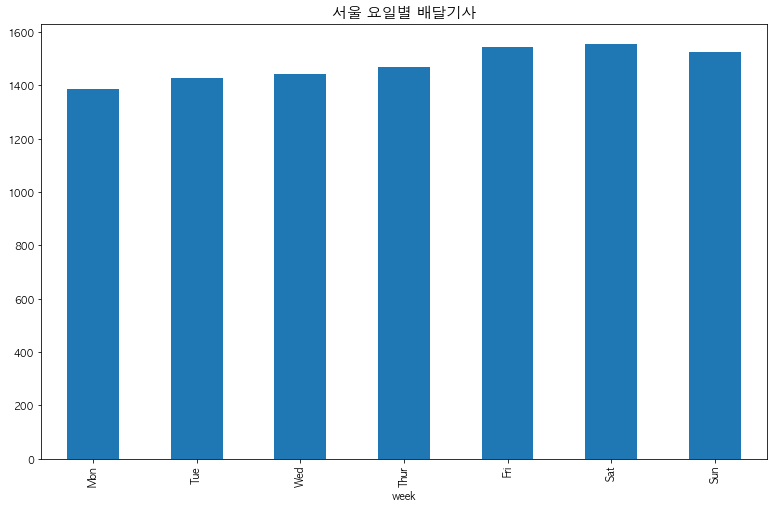

In [84]:
plt.figure(figsize=(13,8))
df_dm_w.groupby('week')['cnt'].mean().plot.bar()
plt.title("서울 요일별 배달기사", fontsize=15)
plt.xticks(index, label, fontsize=10)
#라벨

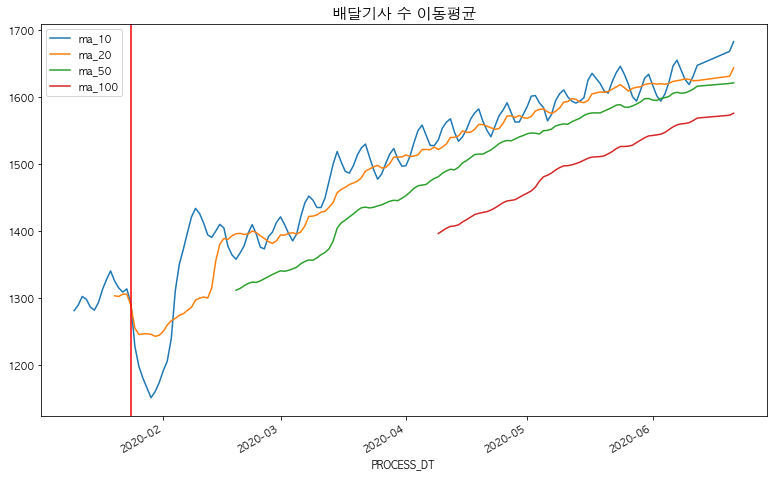

In [85]:
plt.figure(figsize=(13,8))
rolling_mean(df_dm['cnt'])
plt.title("배달기사 수 이동평균", fontsize=15)
plt.axvline('2020-01-24', color='r')

In [86]:
df_del.groupby("DLVR_STORE_INDUTY_NM")["SERIAL_NUMBER"].count().sort_values(ascending=False)

DLVR_STORE_INDUTY_NM
치킨        1173238
한식         658568
분식         626945
카페/디저트     457830
족발/보쌈      415060
패스트푸드      326149
피자         262246
돈까스/일식     251112
야식         226043
찜탕         214388
중식         187030
아시안/양식     109185
회          101095
배달전문업체      94837
도시락         49254
심부름          5344
Name: SERIAL_NUMBER, dtype: int64

#### 배달 품목 데이터

In [87]:
df_del["DLVR_STORE_INDUTY_NM"].unique()

array(['치킨', '찜탕', '한식', '족발/보쌈', '분식', '야식', '돈까스/일식', '회', '피자', '중식',
       '카페/디저트', '심부름', '배달전문업체', '패스트푸드', '아시안/양식', '도시락'], dtype=object)

In [88]:
del_list = []
del_list = df_del["DLVR_STORE_INDUTY_NM"].unique().tolist()

In [89]:
del_list

['치킨',
 '찜탕',
 '한식',
 '족발/보쌈',
 '분식',
 '야식',
 '돈까스/일식',
 '회',
 '피자',
 '중식',
 '카페/디저트',
 '심부름',
 '배달전문업체',
 '패스트푸드',
 '아시안/양식',
 '도시락']

In [90]:
df_menu = df_del[["PROCESS_DT","DLVR_STORE_INDUTY_NM"]].copy()
df_menu

,PROCESS_DT,DLVR_STORE_INDUTY_NM
0,2020-01-01,치킨
1,2020-01-01,찜탕
2,2020-01-01,치킨
3,2020-01-01,한식
4,2020-01-01,한식
...,...,...
5158319,2020-06-21,야식
5158320,2020-06-21,야식
5158321,2020-06-21,야식
5158322,2020-06-21,족발/보쌈


In [91]:
df_menu['month'] = 0

In [92]:
df_menu['PROCESS_DT'] = pd.to_datetime(df_menu['PROCESS_DT'])

Text(0.5, 1.0, '치킨 배달 추이')

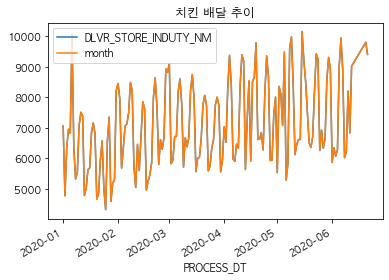

In [93]:
df_menu[df_menu["DLVR_STORE_INDUTY_NM"]=='치킨'].groupby("PROCESS_DT").count().plot()
plt.title("치킨 배달 추이")

In [94]:
chicken = df_menu[df_menu["DLVR_STORE_INDUTY_NM"]=='치킨'].groupby("PROCESS_DT").count()
chicken.head()

,DLVR_STORE_INDUTY_NM,month
PROCESS_DT,,
2020-01-01,7061,7061
2020-01-02,4776,4776
2020-01-03,6350,6350
2020-01-04,6954,6954
2020-01-05,6820,6820


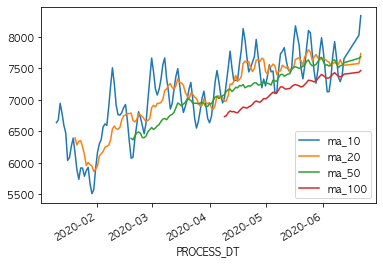

In [95]:
rolling_mean(chicken['DLVR_STORE_INDUTY_NM'])

In [96]:
def menuday(menu) : 
    return df_menu[df_menu["DLVR_STORE_INDUTY_NM"]== menu ].groupby("PROCESS_DT").count()
    

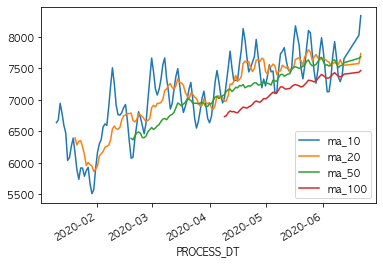

In [97]:
rolling_mean(menuday('치킨')['DLVR_STORE_INDUTY_NM'])

In [98]:
del_list

['치킨',
 '찜탕',
 '한식',
 '족발/보쌈',
 '분식',
 '야식',
 '돈까스/일식',
 '회',
 '피자',
 '중식',
 '카페/디저트',
 '심부름',
 '배달전문업체',
 '패스트푸드',
 '아시안/양식',
 '도시락']

In [99]:
df_menu.head()

,PROCESS_DT,DLVR_STORE_INDUTY_NM,month
0,2020-01-01,치킨,0
1,2020-01-01,찜탕,0
2,2020-01-01,치킨,0
3,2020-01-01,한식,0
4,2020-01-01,한식,0


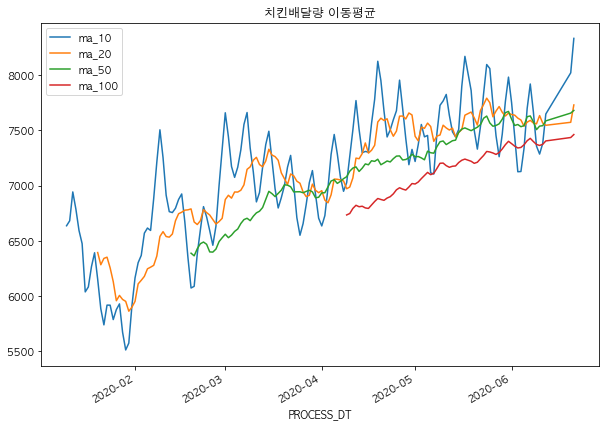

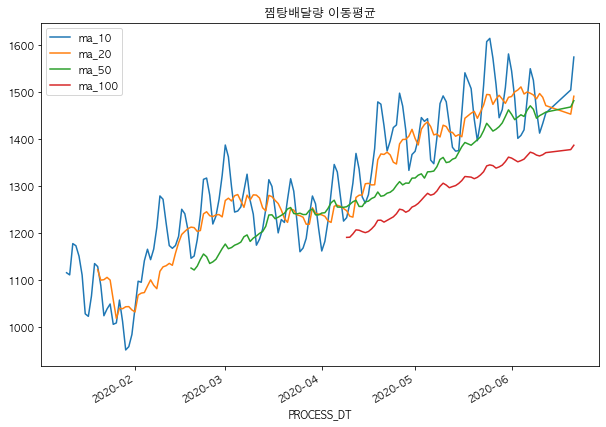

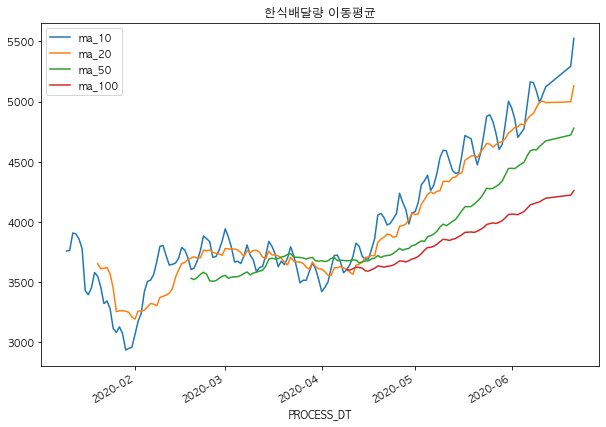

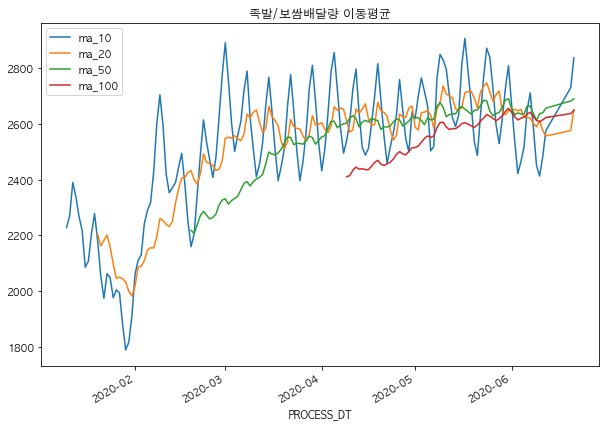

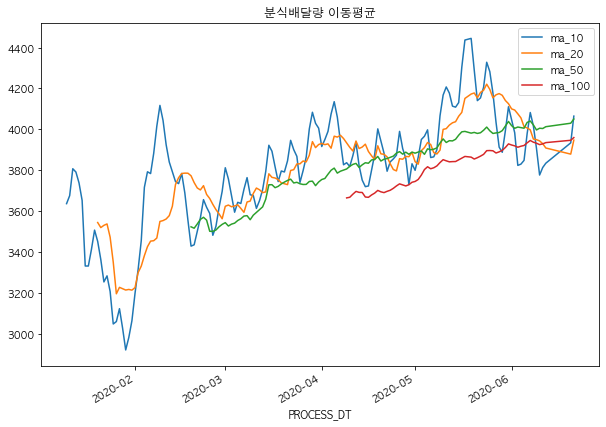

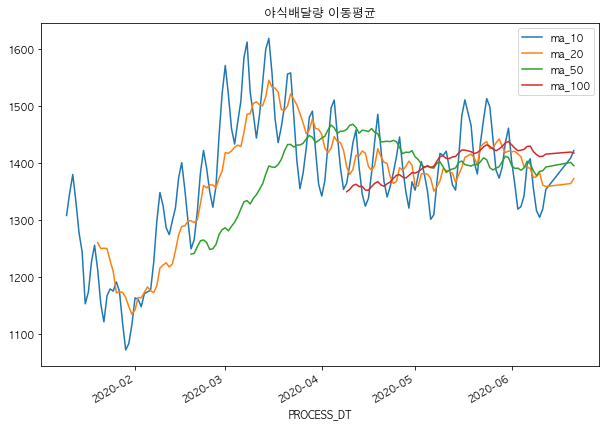

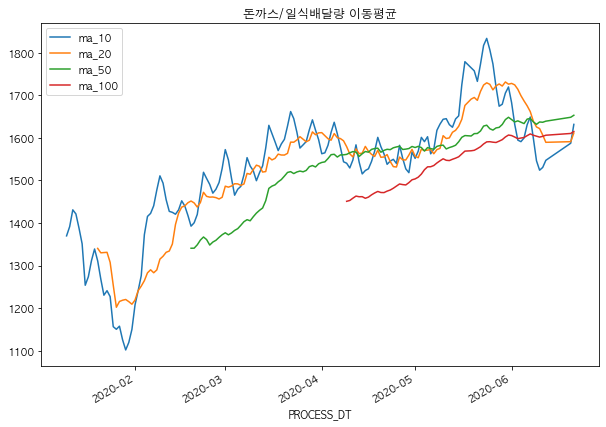

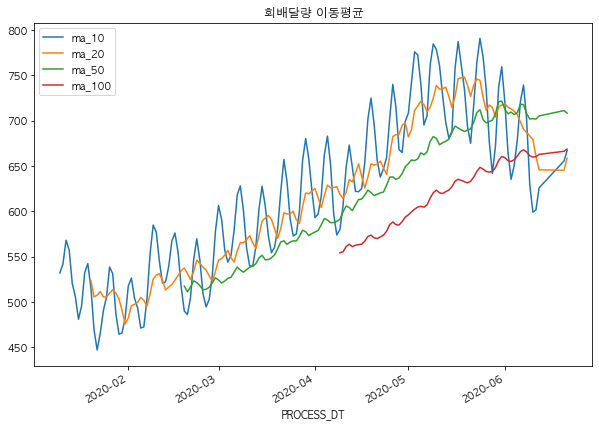

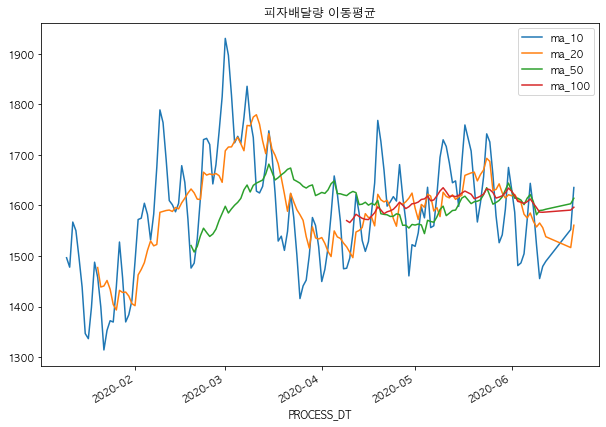

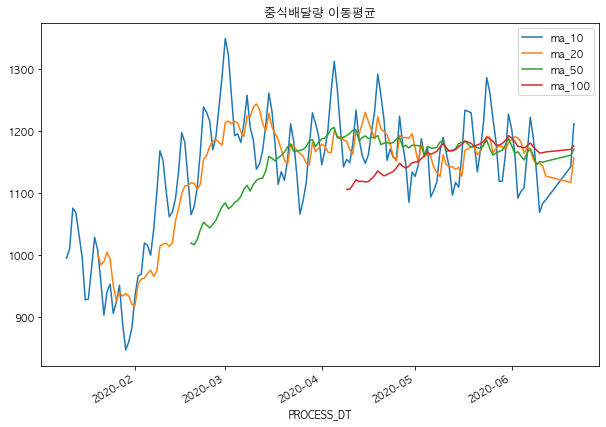

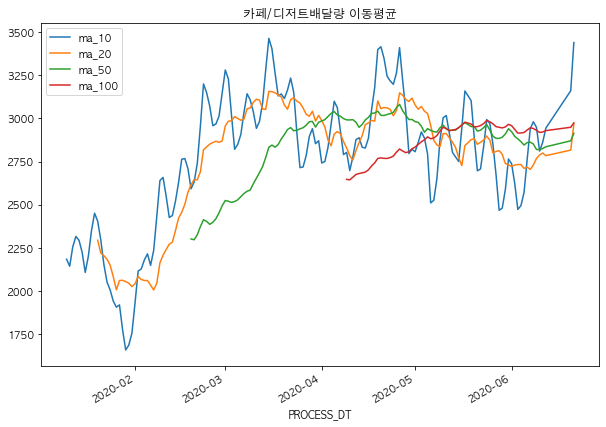

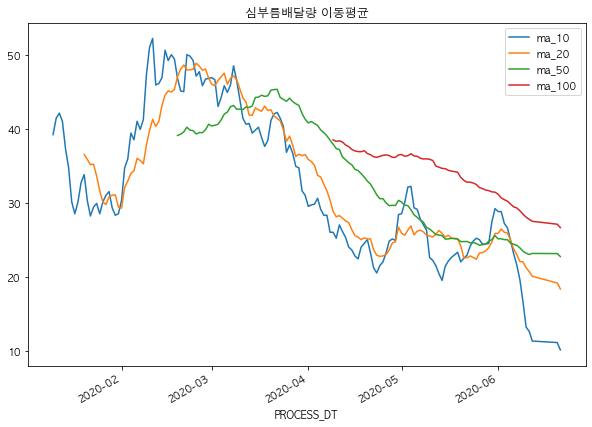

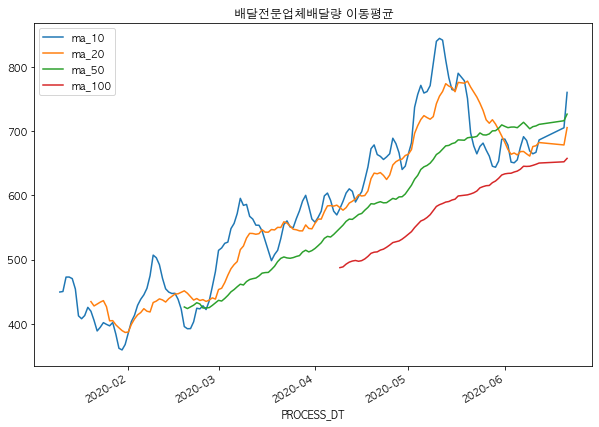

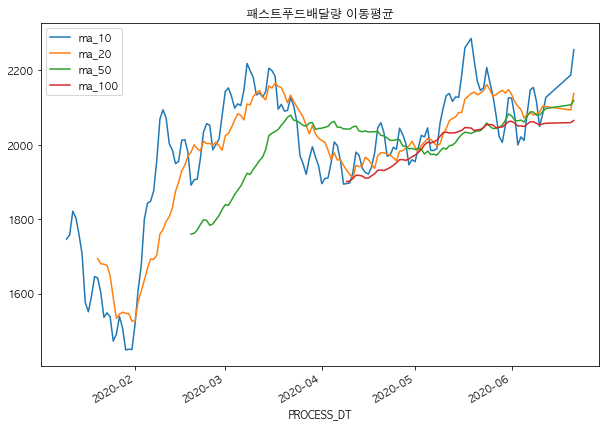

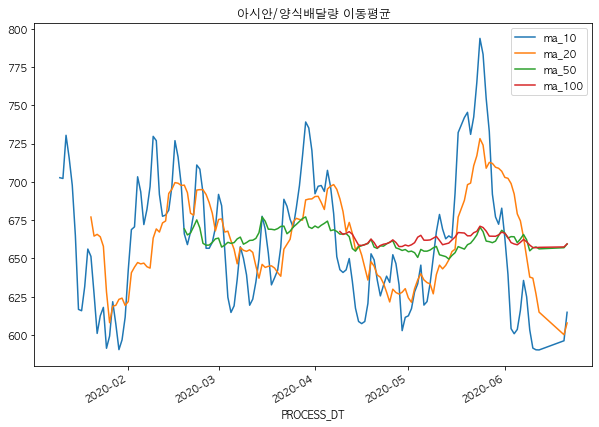

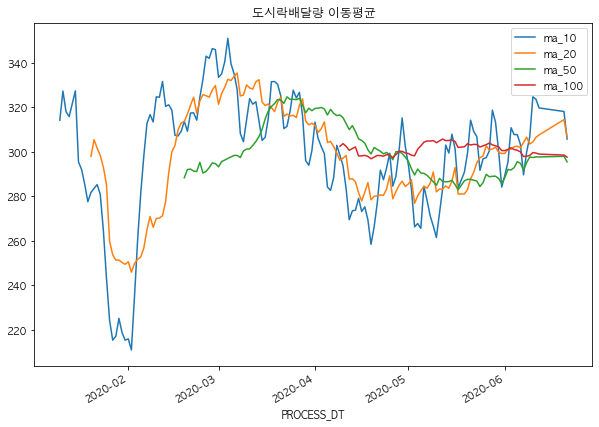

In [100]:
for i in del_list :
    plt.figure(figsize=(10,7))
    rolling_mean(menuday(i)['DLVR_STORE_INDUTY_NM'])
    plt.title(i+"배달량 이동평균")

In [101]:
def menuday2(menu) : 
    df_menu[df_menu["DLVR_STORE_INDUTY_NM"]== menu ].groupby("PROCESS_DT").count().plot()

In [102]:
maindel = ['치킨','족발/보쌈','분식','야식','피자','중식','패스트푸드','아시안/양식','도시락']
subdel = ['찜탕','한식','돈까스/일식','회','카페/디저트']

### 3.7 품목 별 배달량 변화
#### 가설 : 품목별로 배달량의 변화에 차이가 있을 것이다.
- 배달 비주류 음식 배달량 증가 : 찜/탕, 한식, 돈까스/일식, 회, 카페/디저트 중 특히 카페/디저트, 한식 배달량이 눈에 띄게 증가
- 배달 주류 음식 배달량 : 치킨, 족발, 분식, 야식, 피자, 중식, 패스트 푸드,도시락 등 기존에 사람들이 자주 이용하던 메뉴는 소폭 증가.
- 심부름 배달의 경우 코로나가 가장 심했던 3월부터 잠깐 증가했다가 다시 돌아온 것으로 보임.

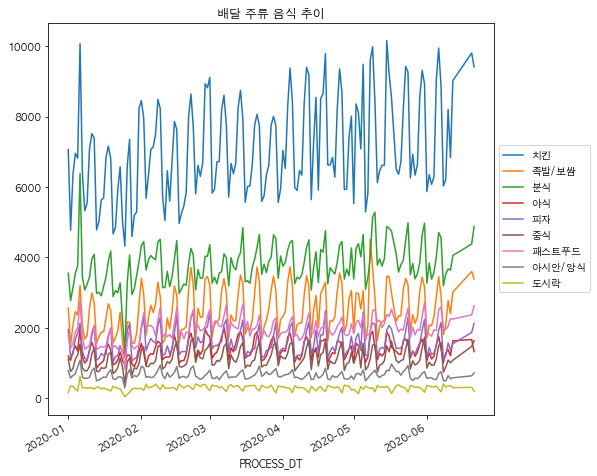

In [103]:
plt.figure(figsize=(8,8))
for i in maindel :
    df_menu[df_menu["DLVR_STORE_INDUTY_NM"]== i ].groupby("PROCESS_DT")["DLVR_STORE_INDUTY_NM"].count().plot()
plt.title("배달 주류 음식 추이")
plt.legend(maindel,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

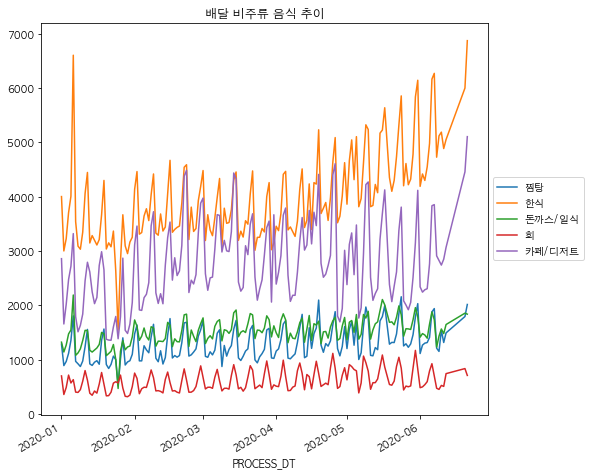

In [104]:
plt.figure(figsize=(8,8))
for i in subdel :
    df_menu[df_menu["DLVR_STORE_INDUTY_NM"]== i ].groupby("PROCESS_DT")["DLVR_STORE_INDUTY_NM"].count().plot()
plt.title("배달 비주류 음식 추이")
plt.legend(subdel,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [105]:
df_menu["main"] = 0
df_menu.head()

,PROCESS_DT,DLVR_STORE_INDUTY_NM,month,main
0,2020-01-01,치킨,0,0
1,2020-01-01,찜탕,0,0
2,2020-01-01,치킨,0,0
3,2020-01-01,한식,0,0
4,2020-01-01,한식,0,0


In [106]:
for i in maindel :
    df_menu["main"][df_menu["DLVR_STORE_INDUTY_NM"]== i ] = "main"
df_menu.head()

<ipython-input-106-ca2e136c23c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_menu["main"][df_menu["DLVR_STORE_INDUTY_NM"]== i ] = "main"


,PROCESS_DT,DLVR_STORE_INDUTY_NM,month,main
0,2020-01-01,치킨,0,main
1,2020-01-01,찜탕,0,0
2,2020-01-01,치킨,0,main
3,2020-01-01,한식,0,0
4,2020-01-01,한식,0,0


In [107]:
for i in subdel :
    df_menu["main"][df_menu["DLVR_STORE_INDUTY_NM"]== i ] = "sub"
df_menu.head()

<ipython-input-107-19d035a5932d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_menu["main"][df_menu["DLVR_STORE_INDUTY_NM"]== i ] = "sub"


,PROCESS_DT,DLVR_STORE_INDUTY_NM,month,main
0,2020-01-01,치킨,0,main
1,2020-01-01,찜탕,0,sub
2,2020-01-01,치킨,0,main
3,2020-01-01,한식,0,sub
4,2020-01-01,한식,0,sub


<Figure size 576x576 with 0 Axes>

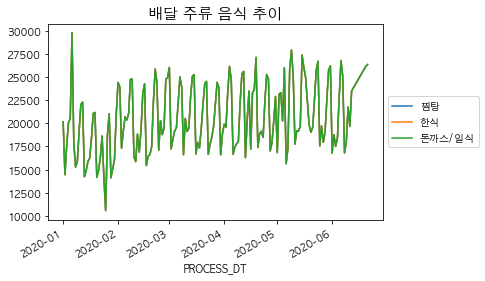

In [108]:
plt.figure(figsize=(8,8))
df_menu[df_menu["main"]== "main"].groupby("PROCESS_DT").count().plot(legend=False)
plt.title("배달 주류 음식 추이", fontsize=15)
plt.legend(subdel,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 576x576 with 0 Axes>

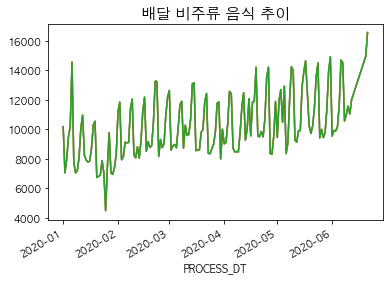

In [109]:
plt.figure(figsize=(8,8))
df_menu[df_menu["main"]== "sub"].groupby("PROCESS_DT").count().plot(legend=False)
plt.title("배달 비주류 음식 추이", fontsize=15)
plt.show()

In [110]:
df_main_cnt = df_menu[df_menu["main"]== "main"].groupby("PROCESS_DT").count()

In [111]:
df_sub_cnt = df_menu[df_menu["main"]== "sub"].groupby("PROCESS_DT").count()

Text(0.5, 1.0, '배달 주류 음식 이동평균')

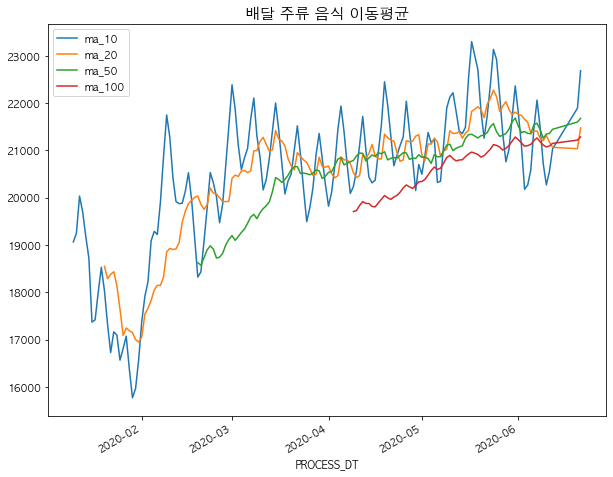

In [112]:
plt.figure(figsize=(10,8))
rolling_mean(df_main_cnt["main"])
plt.title("배달 주류 음식 이동평균", fontsize=15)

Text(0.5, 1.0, '배달 비주류 음식 이동평균')

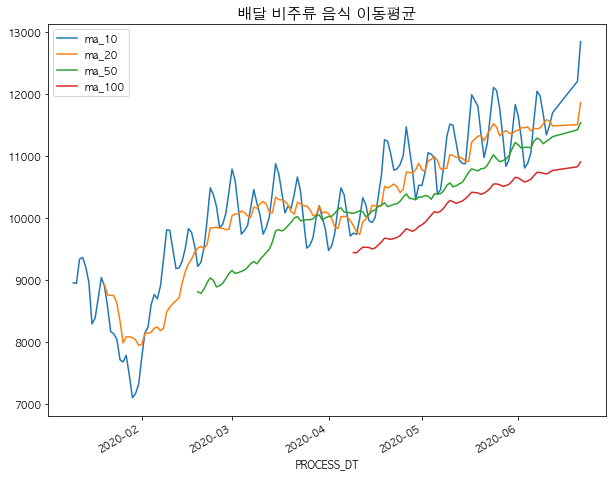

In [113]:
plt.figure(figsize=(10,8))
rolling_mean(df_sub_cnt["main"])
plt.title("배달 비주류 음식 이동평균", fontsize=15)

Text(0.5, 1.0, '비주류 항목 이동평균')

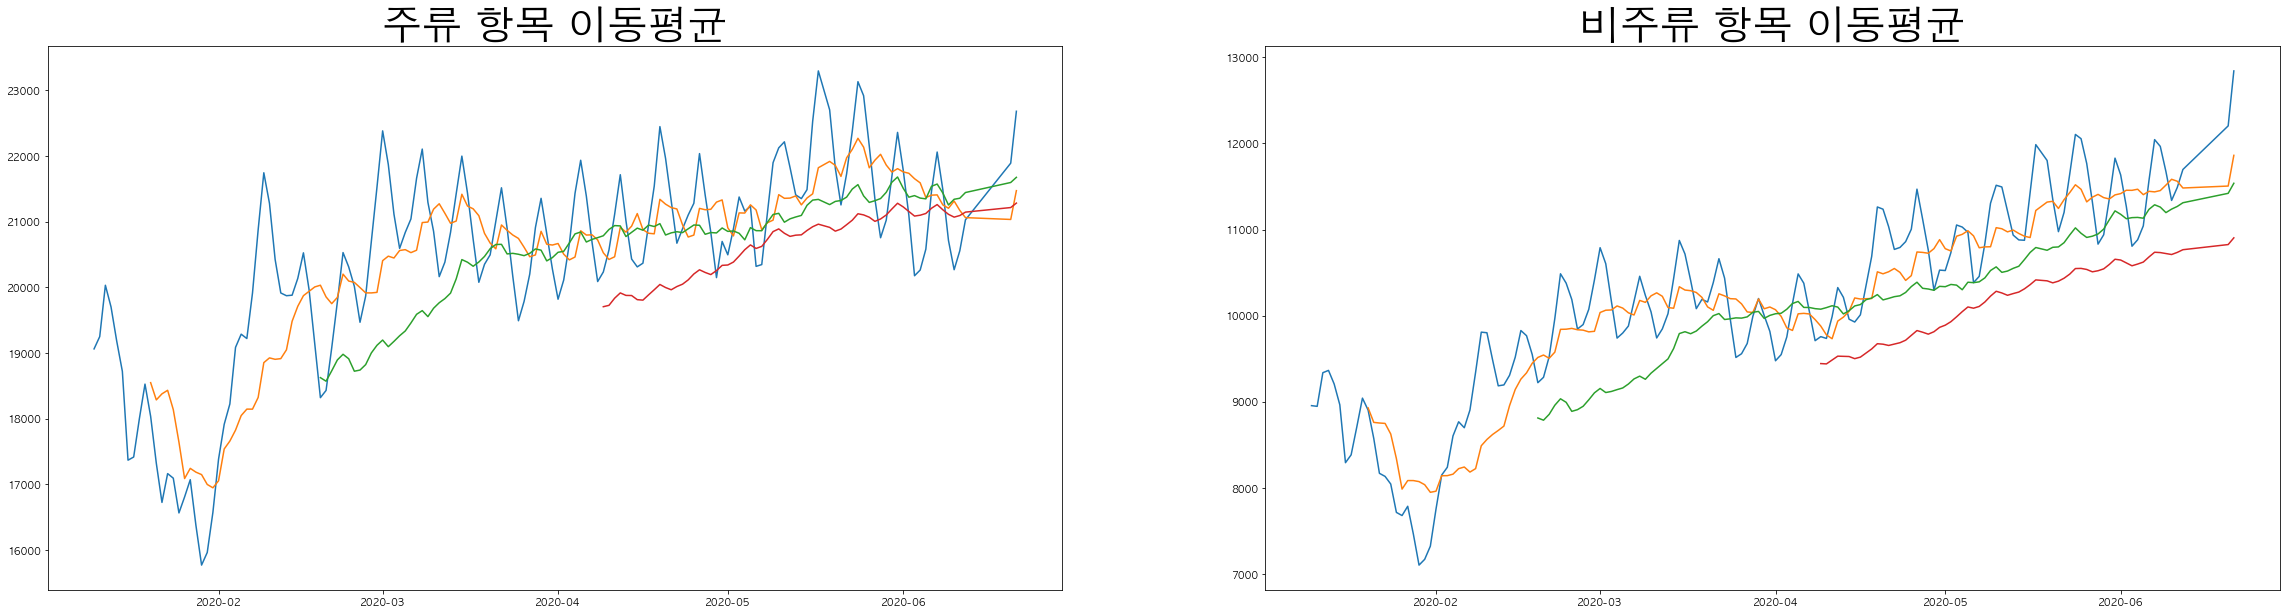

In [114]:
fig, ax = plt.subplots(1, 2,figsize=(40,10)) # 각 액자들에 그래프를 그린다. 
ax[0].plot(df_main_cnt["main"].rolling(10).mean()) 
ax[0].plot(df_main_cnt["main"].rolling(20).mean()) 
ax[0].plot(df_main_cnt["main"].rolling(50).mean()) 
ax[0].plot(df_main_cnt["main"].rolling(100).mean()) 
ax[0].set_title("주류 항목 이동평균",fontsize =40)


ax[1].plot(df_sub_cnt["main"].rolling(10).mean()) 
ax[1].plot(df_sub_cnt["main"].rolling(20).mean()) 
ax[1].plot(df_sub_cnt["main"].rolling(50).mean()) 
ax[1].plot(df_sub_cnt["main"].rolling(100).mean()) 
ax[1].set_title("비주류 항목 이동평균",fontsize =40)



In [115]:
df_del.head()

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,...,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME
0,4577985,2020-01-01,C000035,1,C000035,S0032342,치킨,4812710600,경상남도,창원시 마산회원구,...,D0005271,4290,300,25000,1,승인:비씨카드사,2020-01-01 00:15:49,2020-01-01 00:21:38,2020-01-01 00:41:37,NaN
1,4577986,2020-01-01,C000237,1,C000237,S0021847,찜탕,4121010200,경기도,광명시,...,D0003269,4800,200,49000,2,NaN,2020-01-01 01:12:14,2020-01-01 01:21:41,2020-01-01 01:31:44,NaN
2,4577988,2020-01-01,C000129,1,C000129,S0025740,치킨,1138010400,서울특별시,은평구,...,D0001536,3300,300,23000,3,승인:,2020-01-01 00:01:14,2020-01-01 00:01:47,2020-01-01 00:18:47,NaN
3,4577989,2020-01-01,C000029,1,C000043,S0039634,한식,4115010100,경기도,의정부시,...,D0005061,4500,300,20000,2,NaN,2020-01-01 01:01:34,2020-01-01 01:28:06,2020-01-01 01:36:48,NaN
4,4577991,2020-01-01,C000130,1,C000130,S0002237,한식,4128112800,경기도,고양시 덕양구,...,D0005215,6500,300,32000,2,NaN,2020-01-01 01:05:06,2020-01-01 01:08:01,2020-01-01 01:29:00,NaN


### 3.8 결제패턴의 변화 1:카드 2 :선불 3 :현금
#### 가설 : 배달원과의 접촉을 피하기 위해서 선불결제가 늘어났을 것이다.
- 카드결제, 선불결제는 증가, 현금 결제는 꾸준히 감소하는 추세 
- 코로나가 가장 심했던 3~4월에 선불결제,카드 사용량이 더욱 증가 했다
- 5월11에 정부 재난 지원금이 나오기 시작. 선불결제와 현금사용이 감소, 카드결제가 증가 하기 시작했다.

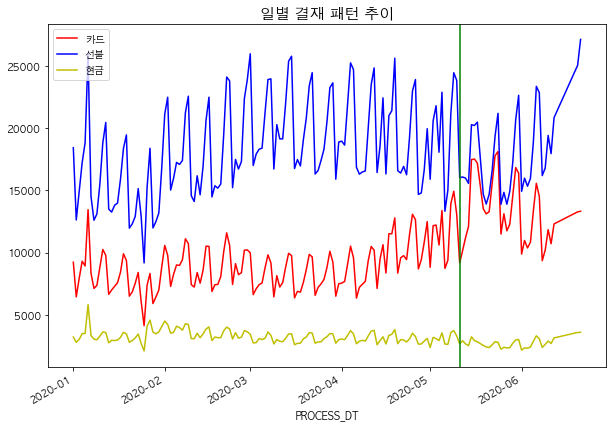

In [116]:
# 1:카드 2:선불 3:현금
plt.figure(figsize=(10,7))
df_del[df_del['SETLE_KND_VALUE']==1 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().plot(c='r') 
df_del[df_del['SETLE_KND_VALUE']==2 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().plot(c='b') 
df_del[df_del['SETLE_KND_VALUE']==3 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().plot(c='y')
plt.axvline('2020-05-11', color='g')
plt.title("일별 결재 패턴 추이", fontsize=15)
plt.legend(['카드','선불','현금'])


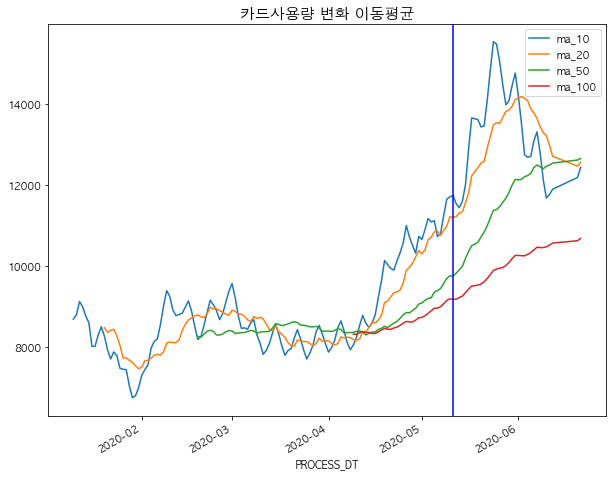

In [117]:
plt.figure(figsize=(10,8))
plt.title("카드사용량 변화 이동평균", fontsize=15)
rolling_mean(df_del[df_del['SETLE_KND_VALUE']==1 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count())
plt.axvline('2020-05-11', color='b')

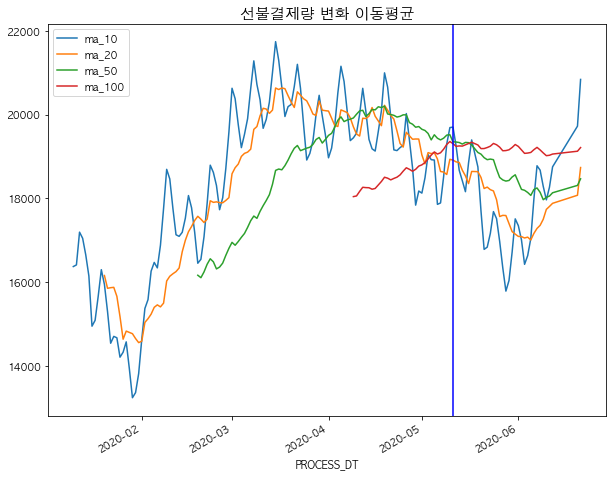

In [118]:
plt.figure(figsize=(10,8))
plt.title("선불결제량 변화 이동평균", fontsize=15)
rolling_mean(df_del[df_del['SETLE_KND_VALUE']==2 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count())
plt.axvline('2020-05-11', color='b')

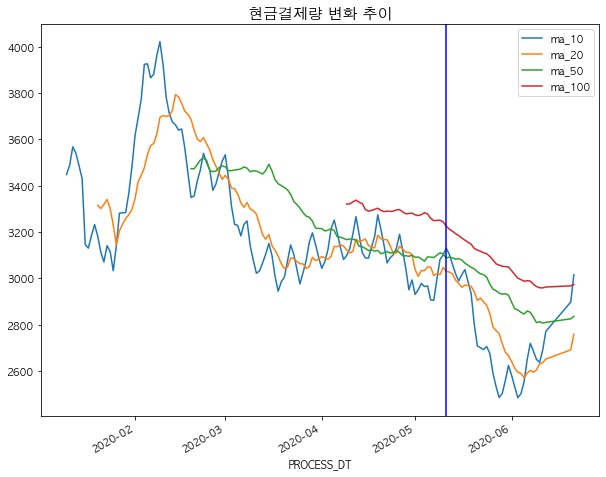

In [119]:
plt.figure(figsize=(10,8))
plt.title("현금결제량 변화 추이", fontsize=15)
rolling_mean(df_del[df_del['SETLE_KND_VALUE']==3 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count())
plt.axvline('2020-05-11', color='b')

Text(0.5, 1.0, '현금 결제량 이동평균')

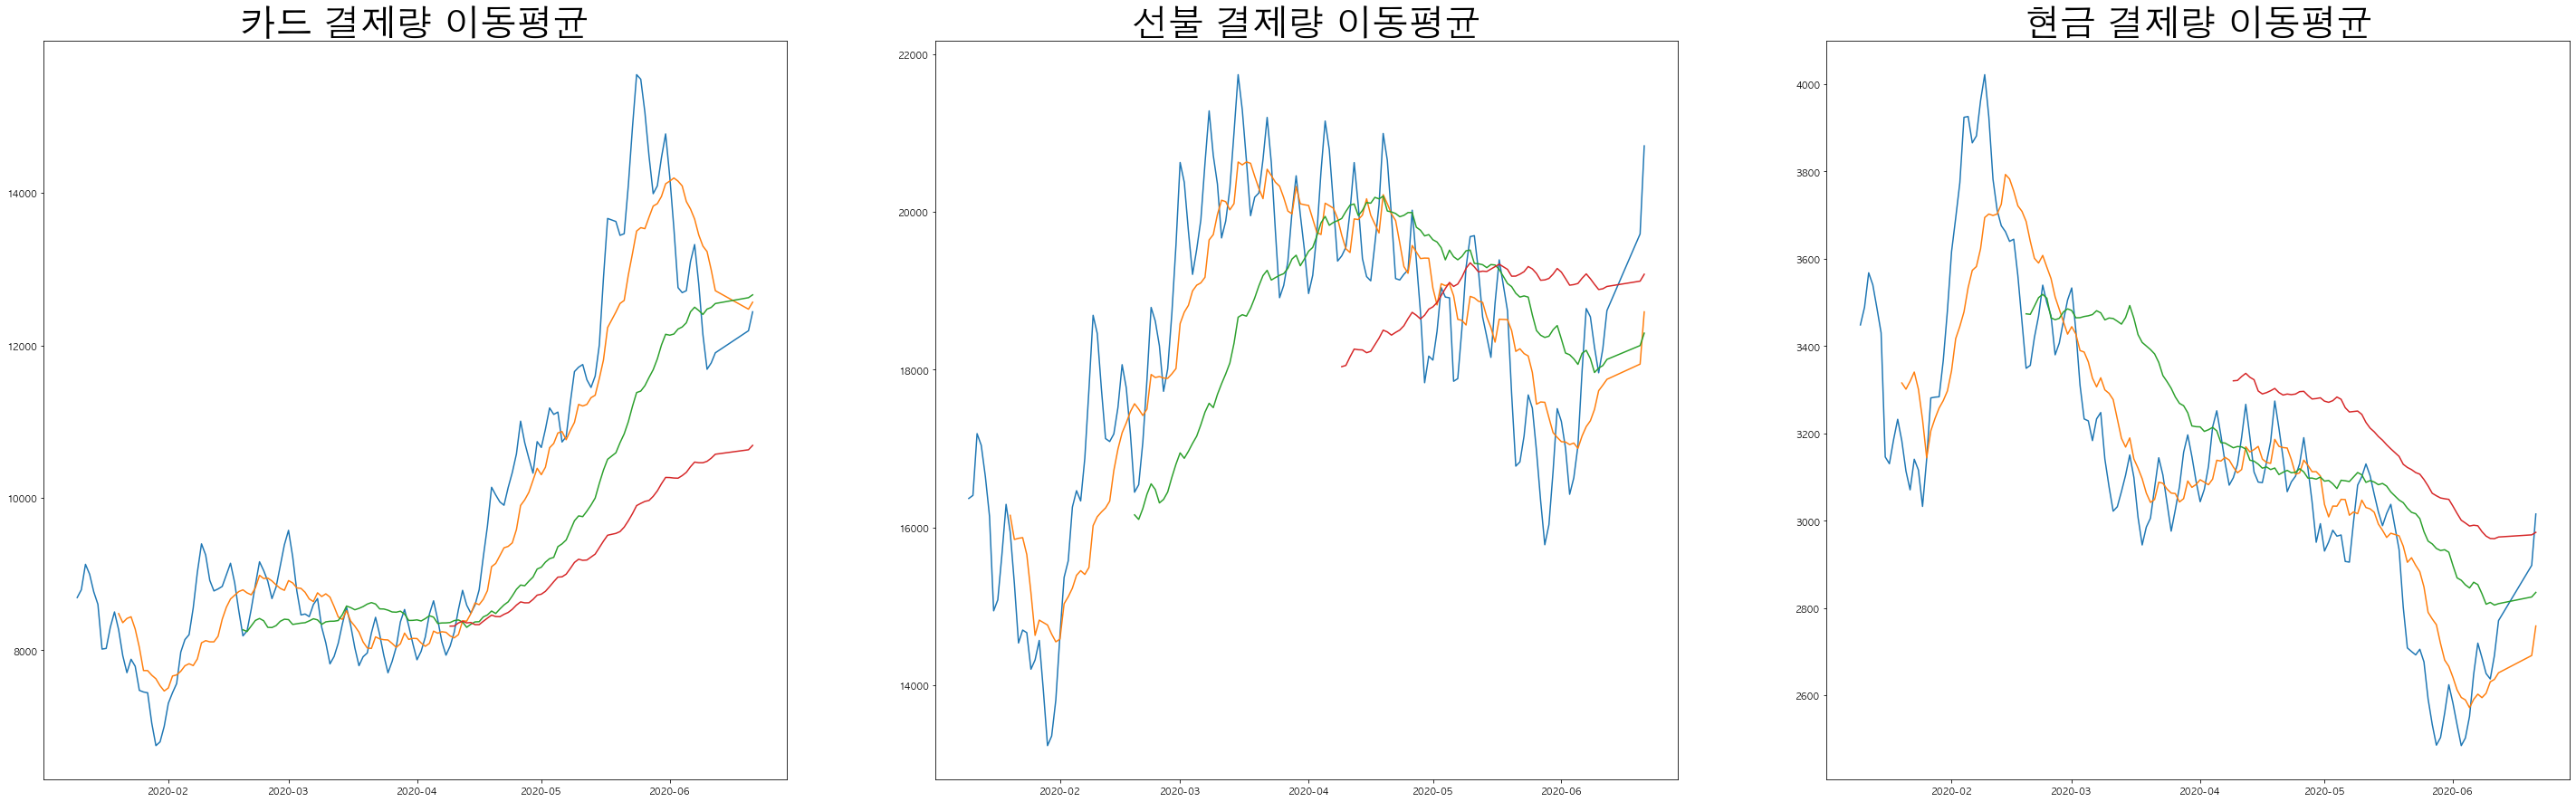

In [120]:
fig, ax = plt.subplots(1, 3,figsize=(50,15)) # 각 액자들에 그래프를 그린다. 
ax[0].plot(df_del[df_del['SETLE_KND_VALUE']==1 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().rolling(10).mean()) 
ax[0].plot(df_del[df_del['SETLE_KND_VALUE']==1 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().rolling(20).mean()) 
ax[0].plot(df_del[df_del['SETLE_KND_VALUE']==1 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().rolling(50).mean()) 
ax[0].plot(df_del[df_del['SETLE_KND_VALUE']==1 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().rolling(100).mean()) 
ax[0].set_title("카드 결제량 이동평균",fontsize =40)


ax[1].plot(df_del[df_del['SETLE_KND_VALUE']==2 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().rolling(10).mean()) 
ax[1].plot(df_del[df_del['SETLE_KND_VALUE']==2 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().rolling(20).mean()) 
ax[1].plot(df_del[df_del['SETLE_KND_VALUE']==2 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().rolling(50).mean()) 
ax[1].plot(df_del[df_del['SETLE_KND_VALUE']==2 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().rolling(100).mean()) 
ax[1].set_title("선불 결제량 이동평균",fontsize =40)


ax[2].plot(df_del[df_del['SETLE_KND_VALUE']==3 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().rolling(10).mean()) 
ax[2].plot(df_del[df_del['SETLE_KND_VALUE']==3 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().rolling(20).mean()) 
ax[2].plot(df_del[df_del['SETLE_KND_VALUE']==3 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().rolling(50).mean()) 
ax[2].plot(df_del[df_del['SETLE_KND_VALUE']==3 ].groupby("PROCESS_DT")["SETLE_KND_VALUE"].count().rolling(100).mean()) 
ax[2].set_title("현금 결제량 이동평균",fontsize =40)

